In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import metrics
import pandas as pd

2024-05-30 14:37:47.518300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 14:37:48.683385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dudder/miniconda3/envs/tf/lib/
2024-05-30 14:37:48.686006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dudder/miniconda3/envs/tf/lib/
2024-05-30 14:37:48.686022: W tensorflow/compiler/tf2t

In [3]:
model_name = 'resnet50_with_batch_norm_extendedV3'

model = tf.keras.models.load_model(f"/mnt/d/datasets/INBREAST/results/{model_name}.keras")

2024-05-30 14:39:26.064336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 14:39:26.094385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 14:39:26.094846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 14:39:26.096248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [16]:
lr = 0.0004
cutoff = 0.5
im_dim_x = 224
im_dim_y = 224
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():  # the entire model needs to be compiled within the scope of the distribution strategy
    # cb1 = EarlyStopping(monitor='val_accuracy', patience=4)  # define early stopping callback function
    cb1 = tf.keras.callbacks.ModelCheckpoint(f"/mnt/d/datasets/INBREAST/results/{model_name}.h5", monitor="val_loss", verbose=2, save_best_only=True, mode="min")
    # cb2 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2,
    #                         min_lr=0.00001)  # define LR reduction callback function
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    metr = [metrics.BinaryAccuracy(name='accuracy', threshold=cutoff), metrics.AUC(name='auc'),
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall')]
    #                 tfa.metrics.F1Score(name='f1_score')]
    ptmodel = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', classes=2, input_shape=(im_dim_x, im_dim_y, 3),
                         pooling='avg')  # compile resnet152v2 with imagenet weights
    ptmodel.trainable = False  # freeze layers
    ptmodel.layers[-1].trainable = True


    # un-freeze the BatchNorm layers
    # for layer in ptmodel.layers:
    #     if "BatchNormalization" in layer.__class__.__name__:
    #         layer.trainable = False # ??

    last_output = ptmodel.output
    x = tf.keras.layers.Flatten()(last_output)
    # x = tf.keras.layers.Dense(2048, activation='relu')(x)
    # #     x = tf.keras.layers.Dropout(0.15)(x)
    # x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # #    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    # # x = tf.keras.layers.Dropout(0.5, seed=34)(x)
    # x = tf.keras.layers.Dense(64, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(ptmodel.input, x)
    model.compile(optimizer=opt,
                  loss='BinaryCrossentropy',
                  metrics=metr)
    
# Load the model weights
model.load_weights(f'{model_name}_weights.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [19]:
model = tf.keras.models.load_model(f"/mnt/d/datasets/INBREAST/results/{model_name}.keras")

In [12]:
# Check CUDA functionality, restart kernel to change GPUs
gpus = tf.config.list_physical_devices('GPU')
print("*************************************")
print(gpus)
print("*************************************")

cutoff = 0.5
img_height = 224
img_width = 224
batch_size = 6

# setup train, validation, and test folders
traindir = '/mnt/d/datasets/INBREAST/split/train'
valdir = '/mnt/d/datasets/INBREAST/split/validation'
testdir = '/mnt/d/datasets/INBREAST/split/test'
dirName = '2_classes'

*************************************
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
*************************************


In [6]:
# Define function to preprocess images as required by ResNet
def preprocess(images, labels):
    return tf.keras.applications.resnet_v2.preprocess_input(images), labels

testdir = '/mnt/d/datasets/INBREAST/split/test'
test = tf.keras.preprocessing.image_dataset_from_directory(
    testdir, labels='inferred', image_size=(224, 224), batch_size=32)
test_ds = test.map(preprocess)

true_classes = []
predicted_probs = []

for images, labels in test_ds:
    predicted_prob = model(images).numpy()
    true_class = labels.numpy()
    
    predicted_probs.extend(predicted_prob)
    true_classes.extend(true_class)
   


Found 492 files belonging to 2 classes.


AttributeError: 'list' object has no attribute 'numpy'

In [19]:
predicted_probs_list = [ elem[0] for elem in predicted_probs ]
predicted_probs

IndexError: invalid index to scalar variable.

In [28]:
print(np.sum(np.array(predicted_probs) < 0))

0


In [34]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(f'/mnt/d/datasets/INBREAST/results/{model_name}_roc.png')
    plt.show()

In [29]:
predicted_probs = np.where(predicted_probs == 1, 0.99999999, predicted_probs)

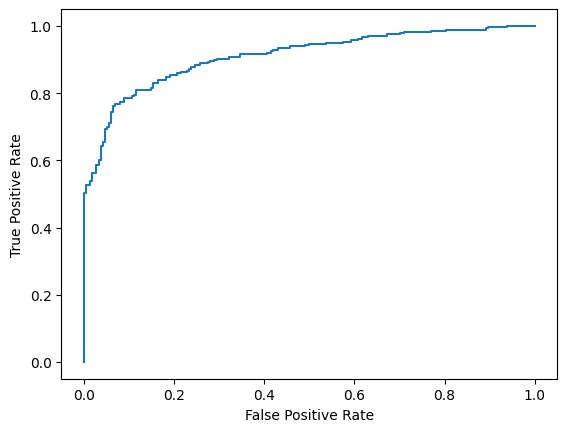

In [35]:
plot_roc_curve(true_classes, predicted_probs)

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(true_y, y_prob, cutoff=0.5):
    """
    Creates and plots a confusion matrix based on the true labels and predicted probabilities.
    
    Parameters:
    - true_y: array-like of shape (n_samples,) containing the true binary labels.
    - y_prob: array-like of shape (n_samples,) containing the predicted probabilities.
    - cutoff: float, the probability threshold to convert probabilities to binary predictions.
    
    Returns:
    - cm: Confusion matrix.
    """
    # Convert predicted probabilities to binary predictions using the cutoff
    y_pred = (y_prob >= cutoff).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(true_y, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (cutoff={cutoff})')
    plt.savefig(f'/mnt/d/datasets/INBREAST/results/{model_name}_conf.png')
    plt.show()
    
    return cm

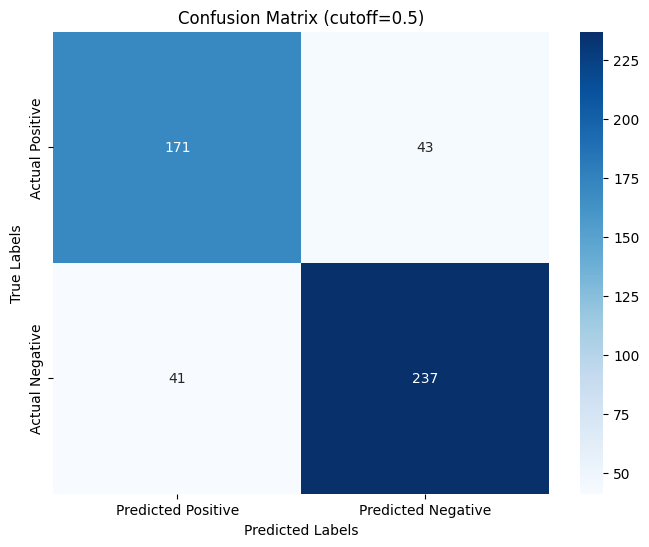

Confusion Matrix:
[[171  43]
 [ 41 237]]


In [49]:
cutoff = 0.5

cm = make_confusion_matrix(true_classes, predicted_probs, cutoff=cutoff)
print("Confusion Matrix:")
print(cm)

In [24]:
batches = []
images = []
labels = []
prediction = []

# Iterate over the dataset
for batch in test_ds:
    batch_images, batch_labels = batch
    batches.append(batch_images.numpy())
    images.extend(batch_images.numpy())
    labels.extend(batch_labels.numpy())

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

for i, image in enumerate(images[0:10]):
    plt.imshow(image.astype("uint8"), vmin=0, vmax=255, interpolation='nearest')
    plt.title(f'Label: {labels[i]} Prediction: {predictions[i]}')
    plt.axis('off')  # Turn off axis
    plt.show()

ValueError: in user code:

    File "/home/dudder/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/dudder/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dudder/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/dudder/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/dudder/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/dudder/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 1 input(s), but it received 82 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 224, 224, 3) dtype=float32>]


In [18]:
# Define function to preprocess images as required by ResNet
def preprocess(images, labels):
    return tf.keras.applications.resnet_v2.preprocess_input(images), labels

test = tf.keras.preprocessing.image_dataset_from_directory(
    testdir, image_size=(img_width, img_height), batch_size=batch_size)

test_ds = test.map(preprocess)

Found 492 files belonging to 2 classes.


In [19]:
testloss, testaccuracy, testauc, precision, recall = model.evaluate(test_ds)
print('Test accuracy :', testaccuracy)
print('Test AUC :', testauc)

F1 = 2 * float(precision) * float(recall) / (float(precision) + float(recall))
print('Test F1 :', F1)
print('Test precision :', precision)
print('Test recall :', recall)

# Model path setup.
if not os.path.exists('/mnt/d/datasets/INBREAST/results/' + model_name + '/' + dirName):
    os.makedirs('/mnt/d/datasets/INBREAST/results/' + model_name + '/' + dirName + '/')

model.save('/mnt/d/datasets/INBREAST/results/' + model_name + '/' + dirName + '/custom_cnn_v_1')
predicted_probs = np.array([])
true_classes = np.array([])
IterationChecker = 0
for images, labels in test_ds:
    if IterationChecker == 0:
        predicted_probs = model(images)
        true_classes = labels.numpy()

    IterationChecker += 1

    predicted_probs = np.concatenate([predicted_probs,
                                      model(images)])
    true_classes = np.concatenate([true_classes, labels.numpy()])
# Since they are sigmoid outputs, you need to transform them into classes with a threshold, i.e 0.5 here:
predicted_classes = [1 * (x[0] >= cutoff) for x in predicted_probs]
# confusion matrix etc:
conf_matrix = tf.math.confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

predicted_probs = np.squeeze(predicted_probs)
predicted_classes = np.array(predicted_classes)
true_classes = np.squeeze(true_classes)
summedResults = np.stack((predicted_probs, predicted_classes, true_classes), axis=1)
##Print out statistics which test files are correctly predicted or not.
np.savetxt('/mnt/d/datasets/INBREAST/results/' + model_name + '.csv', summedResults, delimiter=',',
           header="predicted_probabilty,predicted_classes,true_classes", comments="")

82/82 [==============================] - 6s 70ms/step - loss: 0.8055 - accuracy: 0.8069 - auc: 0.8685 - precision: 0.8427 - recall: 0.8094
Test accuracy : 0.8069105744361877
Test AUC : 0.8684697151184082
Test F1 : 0.8256880623394667
Test precision : 0.8426966071128845
Test recall : 0.8093525171279907


INFO:tensorflow:Assets written to: /mnt/d/datasets/INBREAST/results/resnet50/2_classes/custom_cnn_v_1/assets


INFO:tensorflow:Assets written to: /mnt/d/datasets/INBREAST/results/resnet50/2_classes/custom_cnn_v_1/assets


tf.Tensor(
[[172  42]
 [ 55 229]], shape=(2, 2), dtype=int32)
